In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

stock_data = yf.download('AAPL', start='2016-01-01', end='2021-10-01')
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,25.652500,26.342501,25.500000,26.337500,24.041485,270597600
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.439024,223164000
2016-01-06,25.139999,25.592501,24.967501,25.174999,22.980331,273829600
2016-01-07,24.670000,25.032499,24.107500,24.112499,22.010454,324377600
2016-01-08,24.637501,24.777500,24.190001,24.240000,22.126837,283192000


In [11]:
import pyodbc
import yfinance as yf
import pandas as pd

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)
cursor = cnxn.cursor()

# Tabelle prüfen
table_name = "stock_data"  # Name der Zieltabelle
start_date = "2016-01-01"  # Startdatum, ab dem Daten überprüft werden sollen
end_date = "2021-10-01"  # Enddatum, bis zu dem Daten überprüft werden sollen

# Daten aus der Tabelle in einen DataFrame laden
select_query = f"SELECT * FROM {table_name} WHERE timestamp >= ? AND timestamp <= ?"
df_existing_data = pd.read_sql(select_query, cnxn, params=(start_date, end_date))

# Verbindung schließen
cursor.close()
cnxn.close()

# DataFrame anzeigen
print(df_existing_data.head())


   id  timestamp       open       high        low      close     volume
0   1 2016-01-04  25.652500  26.342501  25.500000  26.337500  270597600
1   2 2016-01-05  26.437500  26.462500  25.602501  25.677500  223164000
2   3 2016-01-06  25.139999  25.592501  24.967501  25.174999  273829600
3   4 2016-01-07  24.670000  25.032499  24.107500  24.112499  324377600
4   5 2016-01-08  24.637501  24.777500  24.190001  24.240000  283192000


C:\Users\HerbyHerb\AppData\Local\Temp\ipykernel_11192\2155649764.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_existing_data = pd.read_sql(select_query, cnxn, params=(start_date, end_date))


Text(0, 0.5, 'Prices ($)')

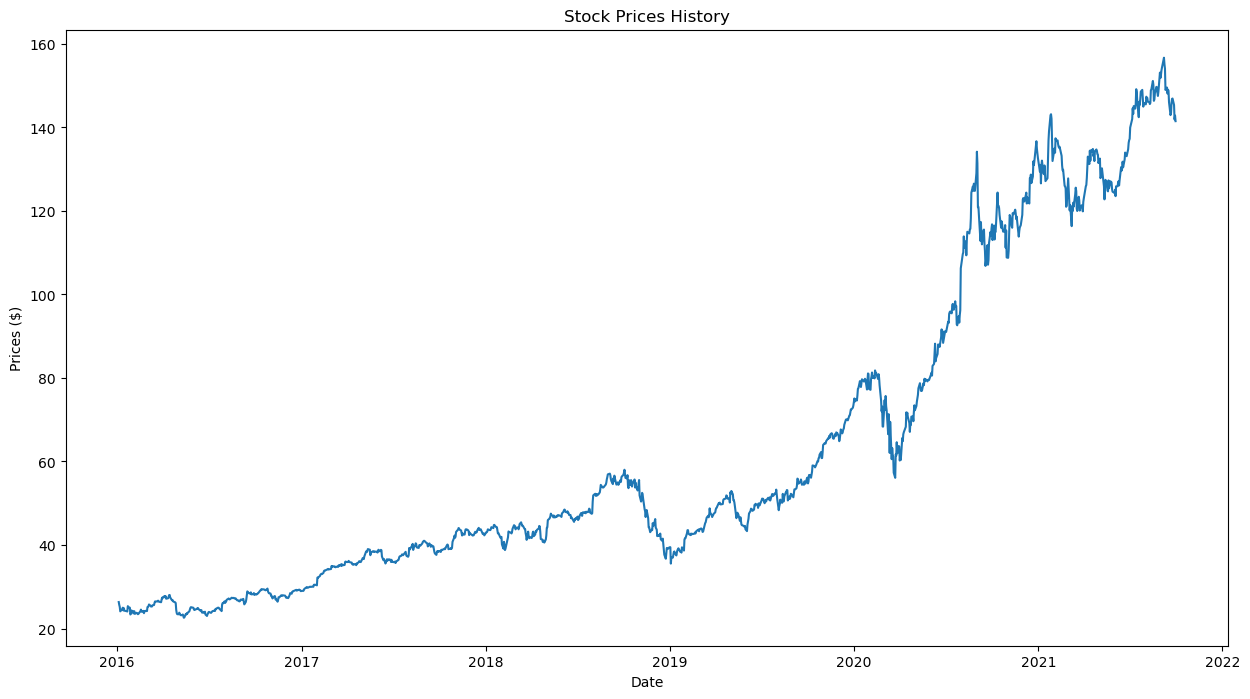

In [2]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [3]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [4]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [5]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
1098/1098 [==============================] - 28s 21ms/step - loss: 8.3531e-04
Epoch 2/3
1098/1098 [==============================] - 22s 20ms/step - loss: 4.9539e-04
Epoch 3/3
1098/1098 [==============================] - 23s 21ms/step - loss: 2.2422e-04


In [7]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

10/10 [==============================] - 2s 27ms/step


1.9834042717428768

C:\Users\HerbyHerb\AppData\Local\Temp\ipykernel_11192\154904543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


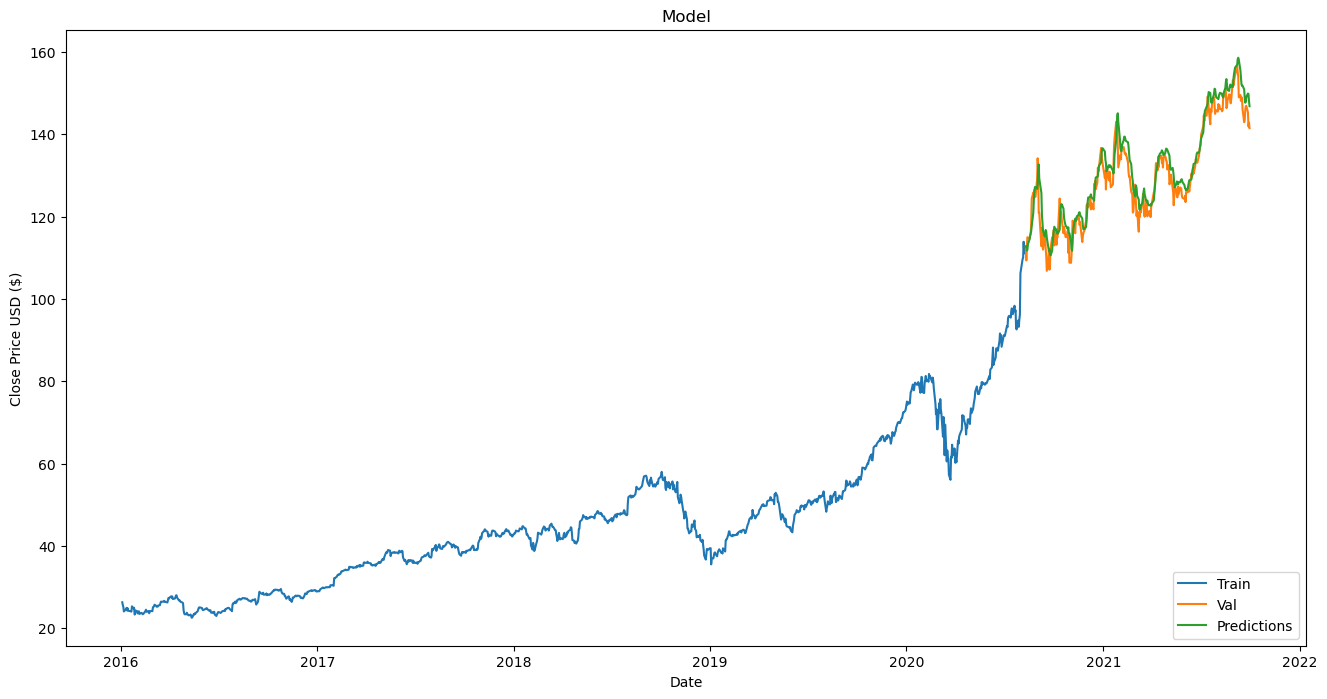

In [8]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()